In [1]:
import torch.nn as nn
import numpy as np
import logging
import torch

from PIL import Image
from torchvision import transforms

class EmbeddingClassifier:
    def __init__(self, model_path, data_set_path, indexes_of_elements, device='cpu', THRESHOLD = 6.84):
        self.device = device
        self.THRESHOLD = THRESHOLD
        self.map_of_items = indexes_of_elements['list_of_ids']
        self.categories = indexes_of_elements['categories']
        self.softmax = nn.Softmax(dim=1)
        
        self.model = torch.jit.load(model_path)
        self.model.eval()
        self.model.to(device)
        
        self.loader = transforms.Compose([
            transforms.Resize((224, 224), Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.data_base = torch.load(data_set_path).to(device)
        logging.info("[INIT][CLASSIFICATION] Initialization of classifier was finished")
                
    def __inference(self, image, top_k = 15): 
        logging.info("[PROCESSING][CLASSIFICATION] Getting embedding for a single detection mask")
        
        dump_embed, fc_output = self.model(image.unsqueeze(0).to(self.device))
        
        logging.info("[PROCESSING][CLASSIFICATION] Classification by Full Connected layer for a single detection mask")  
        classes, _ = self.__classify_fc(fc_output)
        
        fc_recognized = self.categories[str(classes[0].item())]
        
        logging.info("[PROCESSING][CLASSIFICATION] Classification by embedding for a single detection mask")
        output_by_embeddings = self.__classify_embedding(dump_embed[0], top_k)
        
        logging.info("[PROCESSING][CLASSIFICATION] Beautify output for a single detection mask")
        result = self.__beautifier_output(output_by_embeddings, fc_recognized)
        return result
                        
    def __beautifier_output(self, output_by_embeddings, classification_label):
        dict_results = []
        already_writed = []
        
        for class_map in output_by_embeddings:
            if class_map['name'] not in already_writed:
                dict_results.append(class_map)
                already_writed.append(class_map['name'])
            else:
                pass
                
        if classification_label['name'] not in already_writed:
            logging.info("[PROCESSING][CLASSIFICATION] Append into output classification result by FC - layer")
            dict_results.append(
                {
                    'name': classification_label['name'],
                    'species_id': classification_label['species_id'],
                    'distance': self.THRESHOLD,
                    'accuracy': 0.01,
                    'image_id': None,
                    'annotation_id': None,
                    'drawn_fish_id': None,
                }
                
            )
        return dict_results
    
    def __get_confidence(self, dist):
        min_dist = 3.5
        max_dist = self.THRESHOLD
        delta = max_dist - min_dist
        return 1.0 - (max(min(max_dist, dist), min_dist) - min_dist) / delta
    
    def inference_numpy(self, img, top_k=10):
        image = Image.fromarray(img)
        image = self.loader(image)
        
        return self.__inference(image, top_k)
    
    def batch_inference(self, imgs):
        batch_input = []
        for idx in range(len(imgs)):
            image = Image.fromarray(imgs[idx])
            image = self.loader(image)
            batch_input.append(image)

        batch_input = torch.stack(batch_input)
        dump_embeds, class_ids = self.model(batch_input)
        
        logging.info("[PROCESSING][CLASSIFICATION] Classification by Full Connected layer for a single detection mask")  
        classes, scores = self.__classify_fc(class_ids)
       
        outputs = []
        for output_id in range(len(classes)):

            logging.info("[PROCESSING][CLASSIFICATION] Classification by embedding for a single detection mask")
            output_by_embeddings = self.__classify_embedding(dump_embeds[output_id])
            result = self.__beautifier_output(output_by_embeddings, self.categories[str(classes[output_id].item())])
            outputs.append(result)
        return outputs
    
    def __classify_fc(self, output):
        acc_values = self.softmax(output)
        class_id = torch.argmax(acc_values, dim=1)
        #print(f"Recognized species id {class_id} with liklyhood: {acc_values[0][class_id]}")
        return class_id, acc_values

    def __classify_embedding(self, embedding, top_k = 15):
        diff = (self.data_base - embedding).pow(2).sum(dim=1).sqrt()
        val, indi = torch.sort(diff)
        
        embedding_classification_output = []
        for indiece in indi[:top_k]:
            internal_id, image_id, annotation_id, drawn_fish_id = \
            self.map_of_items[indiece]
                   
            class_info_map  = {
                'name': self.categories[str(internal_id)]['name'],
                'species_id': self.categories[str(internal_id)]['species_id'],
                'distance': diff[indiece].item(),
                'accuracy': round(self.__get_confidence(diff[indiece].item()), 3),
                'image_id': image_id,
                'annotation_id': annotation_id,
                'drawn_fish_id': drawn_fish_id,
            }
            embedding_classification_output.append(class_info_map)
        return embedding_classification_output

    
    def __get_species_name(self, category_name):
        for i in self.categories:
            if self.categories[i]['name'] == category_name:
                return self.categories[i]['species_id']

In [2]:
import logging
import time

import cv2
import numpy as np
from PIL import Image
from shapely.geometry import Polygon
import torch
from torch.nn import functional as F

class SegmentationInference:
    
    def __init__(self, model_path):        
        self.model = torch.jit.load(model_path)
        self.MIN_SIZE_TEST = 800
        self.MAX_SIZE_TEST = 1333
        
        self.SCORE_THRESHOLD = 0.3
        self.MASK_THRESHOLD = 0.3
        self.NMS_THRESHOLD = 0.9
        
    def get_set_up(self):
        return {
            'MIN_SIZE_TEST': self.MIN_SIZE_TEST,
            'MAX_SIZE_TEST': self.MAX_SIZE_TEST,
            'SCORE_THRESHOLD': self.SCORE_THRESHOLD,
            'MASK_THRESHOLD': self.MASK_THRESHOLD,
            'NMS_THRESHOLD': self.NMS_THRESHOLD,
        }
    
    def re_init_model(self, threshold):
        try:
            self.SCORE_THRESHOLD = max(0.01, min(0.9, threshold))
        except Exception as e:
            logging.warning('exception', extra={'custom_dimensions': {'error_message': str(e),
                                                                     'place': 're_init_model'}})

    def inference(self, np_img_src):
        start_time = time.time()
        
        #resize img 
        np_img_resized = resize_img_by_shortest_endge(np_img_src, self.MIN_SIZE_TEST, self.MAX_SIZE_TEST)
        
        #get scales of x&y after scaling
        scales = np.divide(np_img_src.shape[:2], np_img_resized.shape[:2])
        
        img_torch_tensor = torch.as_tensor(np_img_resized.astype("float32").transpose(2, 0, 1))
        
        segm_output = self.model(img_torch_tensor)
        mask_and_poly = self.convert_output_to_mask_and_polygons(segm_output, np_img_resized, scales)
        polygons, masks = self.__process_output(mask_and_poly)
        logging.info("Inference time by Mask RCNN models has taken {} [s]".format(round(time.time() - start_time, 2)))
        
        return polygons, masks
    
    def __process_output(self, output):
        
        def is_valid_polygon(polygon_array):
            try:
                Polygon(polygon_array)
                return True
            except Exception as e:
                logging.info(f"[PROCESSING][SEGMENTATION] polygon is broken for current mask - skip it: {e}")
                return False

        poly_instances = np.array([[Polygon(polygon_array), polygon_array, mask] for mask, polygon_array in output if is_valid_polygon(polygon_array)])
        
        poly_instances = sorted(poly_instances, key=lambda x: x[0].area, reverse=True)
        # Create a list of indices to keep
        keep_indices = [0]

        for i in range(1, len(poly_instances)):
            keep = True
            for j in keep_indices:
                keep = self.filter_by_iou_threshold(poly_instances[i][0], poly_instances[j][0])
            if keep:
                keep_indices.append(i)

        logging.info(f"[PROCESSING][SEGMENTATION] After applying custom NMS method removed N = {(len(poly_instances) - len(keep_indices))} indexes")
        
        polygons = [SegmentationInference.poly_array_to_dict(poly_instances[i][1]) for i in keep_indices]
        masks = [poly_instances[i][2] for i in keep_indices]
        
        return polygons, masks
    
    def convert_output_to_mask_and_polygons(self, mask_rcnn_output, np_img_resized, scales):

        def rescale_polygon_to_src_size(poly, start_pont, scales):
            return [[int((start_pont[0] + point[0]) * scales[0]), 
                     int((start_pont[1] + point[1]) * scales[1])] for point in poly]

        boxes, classes, masks, scores, img_size = mask_rcnn_output
        processed = []

        for ind in range(len(masks)):
            if scores[ind] <= self.SCORE_THRESHOLD: continue
            x1, y1, x2, y2 = int(boxes[ind][0]), int(boxes[ind][1]), int(boxes[ind][2]) , int(boxes[ind][3])  
            mask_h, mask_w = y2 - y1, x2 - x1

            np_mask = do_paste_mask(masks[ind, None, :, :], mask_h, mask_w).numpy()[0][0]

            # Threshold the mask converting to uint8 casuse opencv diesn't allow other type! 
            np_mask = np.where(np_mask > self.MASK_THRESHOLD, 255, 0).astype(np.uint8)
            crop_image = np_img_resized[y1:y1 + mask_h, x1:x1+mask_w]
            res = cv2.bitwise_and(crop_image, crop_image, mask = np_mask)

            # Find contours in the binary mask
            contours = bitmap_to_polygon(np_mask)

            # Ignore empty contpurs and small artifacts 
            if len(contours) < 1 or len(contours[0]) < 10:
                continue

            # Convert local polygon to src image
            polygon_full = rescale_polygon_to_src_size(contours[0], (x1, y1), scales)

            processed.append([res, polygon_full])
        return processed
    
    @staticmethod
    def poly_array_to_dict(poly):
        polygons_dict = {}
        for i in range(len(poly)):
            polygons_dict.update({
                "x{}".format(i + 1): poly[i][0],
                "y{}".format(i + 1): poly[i][1]
            })
        return polygons_dict
    
    def filter_by_iou_threshold(self, poly_a, poly_b):
        """
        Checks if the two given polygons intersect.

        Args:
            - poly_a: shapely.geometry.Polygon, first polygon
            - poly_b: shapely.geometry.Polygon, second polygon
            - threshold: float, threshold above which the polygons intersect

        Returns:
            - True if the polygons intersect, False otherwise
        """
        intersection_area = poly_a.intersection(poly_b).area
        union_area = poly_a.union(poly_b).area

        iou = intersection_area / union_area
        if iou > self.NMS_THRESHOLD:
            return False
        return True

# Image utils
def resize_img_by_shortest_endge(img_np, MIN_SIZE_TEST, MAX_SIZE_TEST):
    
    src_h, src_w = img_np.shape[:2]
    new_h, new_w = get_output_shape(src_h, src_w, MIN_SIZE_TEST, MAX_SIZE_TEST)
    img_resized_np = apply_image(img_np, new_h, new_w)
    
    return img_resized_np

def get_output_shape(
    oldh: int, oldw: int, short_edge_length: int, max_size: int) -> [int, int]:
    """
    Compute the output size given input size and target short edge length.
    """
    h, w = oldh, oldw
    size = short_edge_length * 1.0
    scale = size / min(h, w)
    if h < w:
        newh, neww = size, scale * w
    else:
        newh, neww = scale * h, size
    if max(newh, neww) > max_size:
        scale = max_size * 1.0 / max(newh, neww)
        newh = newh * scale
        neww = neww * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def apply_image(img, new_h, new_w, interp_method=Image.BILINEAR):
    assert len(img.shape) <= 4
    
    if img.dtype == np.uint8:
        if len(img.shape) > 2 and img.shape[2] == 1:
            pil_image = Image.fromarray(img[:, :, 0], mode="L")
        else:
            pil_image = Image.fromarray(img)
        pil_image = pil_image.resize((new_w, new_h), interp_method)
        ret = np.asarray(pil_image)
        if len(img.shape) > 2 and img.shape[2] == 1:
            ret = np.expand_dims(ret, -1)
    else:
        # PIL only supports uint8
        if any(x < 0 for x in img.strides):
            img = np.ascontiguousarray(img)
        img = torch.from_numpy(img)
        shape = list(img.shape)
        shape_4d = shape[:2] + [1] * (4 - len(shape)) + shape[2:]
        img = img.view(shape_4d).permute(2, 3, 0, 1)  # hw(c) -> nchw
        _PIL_RESIZE_TO_INTERPOLATE_MODE = {
            Image.NEAREST: "nearest",
            Image.BILINEAR: "bilinear",
            Image.BICUBIC: "bicubic",
        }
        mode = _PIL_RESIZE_TO_INTERPOLATE_MODE[interp_method]
        align_corners = None if mode == "nearest" else False
        img = F.interpolate(
            img, (new_h, new_w), mode=mode, align_corners=align_corners
        )
        shape[:2] = (new_h, new_w)
        ret = img.permute(2, 3, 0, 1).view(shape).numpy()  # nchw -> hw(c)

    return ret

def do_paste_mask(masks, img_h: int, img_w: int):
    """
    Args:
        masks: N, 1, H, W
        boxes: N, 4
        img_h, img_w (int):
        skip_empty (bool): only paste masks within the region that
            tightly bound all boxes, and returns the results this region only.
            An important optimization for CPU.

    Returns:
        if skip_empty == False, a mask of shape (N, img_h, img_w)
        if skip_empty == True, a mask of shape (N, h', w'), and the slice
            object for the corresponding region.
    """
    device = masks.device

    x0_int, y0_int = 0, 0
    x1_int, y1_int = img_w, img_h
    x0, y0, x1, y1 =  torch.Tensor([[0]]), torch.Tensor([[0]]), torch.Tensor([[img_w]]), torch.Tensor([[img_h]])

    N = masks.shape[0]

    img_y = torch.arange(y0_int, y1_int, device=device, dtype=torch.float32) + 0.5
    img_x = torch.arange(x0_int, x1_int, device=device, dtype=torch.float32) + 0.5
    img_y = (img_y - y0) / (y1 - y0) * 2 - 1
    img_x = (img_x - x0) / (x1 - x0) * 2 - 1
    # img_x, img_y have shapes (N, w), (N, h)
    gx = img_x[:, None, :].expand(N, img_y.size(1), img_x.size(1))
    gy = img_y[:, :, None].expand(N, img_y.size(1), img_x.size(1))
    grid = torch.stack([gx, gy], dim=3)

    resized_mask = F.grid_sample(masks, grid.to(masks.dtype), align_corners=False)

    return resized_mask
    
def bitmap_to_polygon(bitmap):
    """Convert masks from the form of bitmaps to polygons.

    Args:
        bitmap (ndarray): masks in bitmap representation.

    Return:
        list[ndarray]: the converted mask in polygon representation.
        bool: whether the mask has holes.
    """
    bitmap = np.ascontiguousarray(bitmap).astype(np.uint8)
    # cv2.RETR_CCOMP: retrieves all of the contours and organizes them
    #   into a two-level hierarchy. At the top level, there are external
    #   boundaries of the components. At the second level, there are
    #   boundaries of the holes. If there is another contour inside a hole
    #   of a connected component, it is still put at the top level.
    # cv2.CHAIN_APPROX_NONE: stores absolutely all the contour points.
    outs = cv2.findContours(bitmap, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    contours = outs[-2]
    hierarchy = outs[-1]
    if hierarchy is None:
        return [], False
    # hierarchy[i]: 4 elements, for the indexes of next, previous,
    # parent, or nested contours. If there is no corresponding contour,
    # it will be -1.
    contours = [c.reshape(-1, 2) for c in contours]
    return sorted(contours, key=len, reverse = True)

In [3]:
#utils

import requests
import json
import os
import cv2

def get_np_img_from_url(url):
    img_data = requests.get(url).content
    return cv2.imdecode(np.asarray(bytearray(img_data), dtype=np.uint8), cv2.IMREAD_COLOR)

def read_json(path):
    if os.path.isfile(path):
        with open(path) as f:
            data = json.load(f)
        return data
    else:
        return None

# Define segmentation and classification model file paths

In [4]:
path_to_classification_model = r'/home/fishial/Fishial/output/classification/resnet_18_triplet_08_09_2023_v06_under_train_cross/model.ts'
path_to_classification_embeddings = r'/home/fishial/Fishial/output/classification/resnet_18_triplet_08_09_2023_v06_under_train_cross/embeddings.pt'
path_to_labels_file = r'/home/fishial/Fishial/output/classification/resnet_18_triplet_08_09_2023_v06_under_train_cross/idx.json'

labels_file = read_json(path_to_labels_file)


In [5]:
model_classifier = EmbeddingClassifier(
    path_to_classification_model,
    path_to_classification_embeddings,
    labels_file,
    device='cpu')

In [6]:
model_path = r'/home/fishial/Fishial/output/segmentation_export_torchscript/model_segm_21_08_2023.ts'
path_to_segmentation_model = r'/home/fishial/Fishial/output/model_21_08_2023.pth'
path_to_segmentation_config = r'/home/fishial/Fishial/detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml'


segmentation_instance = SegmentationInference(model_path)

In [7]:
url = r'https://www.grammar-monster.com/easily_confused/pics/fish_or_fishes.png'

np_img_src = get_np_img_from_url(url)

output = segmentation_instance.inference(np_img_src)

/home/fishial/miniconda3/envs/nemo_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return forward_call(*args, **kwargs)
/tmp/ipykernel_652940/2090692794.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poly_instances = np.array([[Polygon(polygon_array), polygon_array, mask] for mask, polygon_array in output if is_valid_polygon(polygon_array)])
/home/fishial/miniconda3/envs/nemo_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, 

In [8]:
segmentation_instance.get_set_up()

{'MIN_SIZE_TEST': 800,
 'MAX_SIZE_TEST': 1333,
 'SCORE_THRESHOLD': 0.3,
 'MASK_THRESHOLD': 0.3,
 'NMS_THRESHOLD': 0.9}

[[{'name': 'Thunnus atlanticus', 'species_id': '8fe2ce72-971f-4ef9-986a-9b5ab8447839', 'distance': 4.09323787689209, 'accuracy': 0.822, 'image_id': '147660', 'annotation_id': 'cfb1d771-d066-50c7-aa1a-634ea87f6076', 'drawn_fish_id': 333842}, {'name': 'Thunnus albacares', 'species_id': '76b2df83-0902-4108-812a-ce5785540e81', 'distance': 4.3316144943237305, 'accuracy': 0.751, 'image_id': '146952', 'annotation_id': 'e2968e1f-65f6-549d-b085-41cf8d913c05', 'drawn_fish_id': 331767}, {'name': 'Sarda sarda', 'species_id': 'e1e8b6f0-9473-4b43-b584-314da6e435f0', 'distance': 5.267858028411865, 'accuracy': 0.471, 'image_id': '148073', 'annotation_id': '0f7050fb-4276-5d57-af7a-60617a736115', 'drawn_fish_id': 334510}, {'name': 'Scomberomorus cavalla', 'species_id': '504ab5d4-024d-4497-94a8-89f8641f0e4e', 'distance': 5.28117036819458, 'accuracy': 0.467, 'image_id': '16025', 'annotation_id': '1923731b-e1dc-5b46-9780-884884d7f4c2', 'drawn_fish_id': 38423}, {'name': 'Acanthocybium solandri', 'species_id

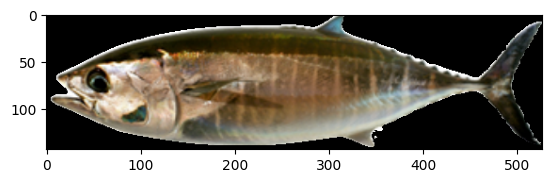

---
[[{'name': 'Thunnus atlanticus', 'species_id': '8fe2ce72-971f-4ef9-986a-9b5ab8447839', 'distance': 3.9886794090270996, 'accuracy': 0.854, 'image_id': '147660', 'annotation_id': 'cfb1d771-d066-50c7-aa1a-634ea87f6076', 'drawn_fish_id': 333842}, {'name': 'Thunnus albacares', 'species_id': '76b2df83-0902-4108-812a-ce5785540e81', 'distance': 4.273653984069824, 'accuracy': 0.768, 'image_id': '146952', 'annotation_id': 'e2968e1f-65f6-549d-b085-41cf8d913c05', 'drawn_fish_id': 331767}]]


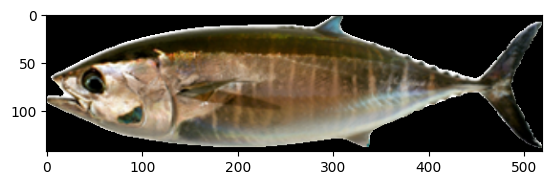

---
[[{'name': 'Thunnus atlanticus', 'species_id': '8fe2ce72-971f-4ef9-986a-9b5ab8447839', 'distance': 3.9212069511413574, 'accuracy': 0.874, 'image_id': '147660', 'annotation_id': 'cfb1d771-d066-50c7-aa1a-634ea87f6076', 'drawn_fish_id': 333842}, {'name': 'Thunnus albacares', 'species_id': '76b2df83-0902-4108-812a-ce5785540e81', 'distance': 4.2898664474487305, 'accuracy': 0.764, 'image_id': '146952', 'annotation_id': 'e2968e1f-65f6-549d-b085-41cf8d913c05', 'drawn_fish_id': 331767}, {'name': 'Acanthocybium solandri', 'species_id': '1f1e4724-fc4b-41b7-8165-f123f98b214e', 'distance': 5.144937038421631, 'accuracy': 0.508, 'image_id': '148318', 'annotation_id': '72f9b2d3-4a78-54a3-bd21-db7d402e6661', 'drawn_fish_id': 1488228}, {'name': 'Scomberomorus cavalla', 'species_id': '504ab5d4-024d-4497-94a8-89f8641f0e4e', 'distance': 5.182629585266113, 'accuracy': 0.496, 'image_id': '16025', 'annotation_id': '1923731b-e1dc-5b46-9780-884884d7f4c2', 'drawn_fish_id': 38423}, {'name': 'Sarda sarda', 'sp

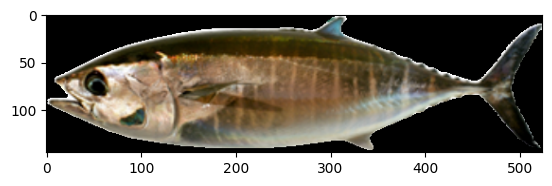

---
[[{'name': 'Dicentrarchus labrax', 'species_id': 'ad47b753-df73-46a3-8b2b-810c9ac146a4', 'distance': 4.166463375091553, 'accuracy': 0.8, 'image_id': '99390', 'annotation_id': 'fb9a95e6-2f08-52dd-9571-de75e637a1d5', 'drawn_fish_id': 1470009}]]


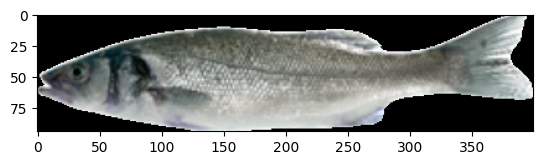

---
[[{'name': 'Dicentrarchus labrax', 'species_id': 'ad47b753-df73-46a3-8b2b-810c9ac146a4', 'distance': 3.95862078666687, 'accuracy': 0.863, 'image_id': '99565', 'annotation_id': 'b40b2676-e0b7-5c7c-9495-8a635594656a', 'drawn_fish_id': 1469118}]]


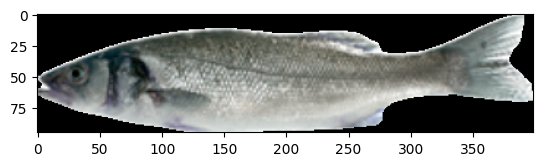

---
[[{'name': 'Gadus morhua', 'species_id': '9046fbda-c0ae-4381-b8b1-973b75ed72bb', 'distance': 5.773092746734619, 'accuracy': 0.319, 'image_id': '302426', 'annotation_id': 'c4a98f63-0738-532d-af91-6e9af7738b38', 'drawn_fish_id': 620234}, {'name': 'Ophiodon elongatus', 'species_id': '45992c6d-a9f9-45d6-a4f2-4b5955a82b4a', 'distance': 5.8491291999816895, 'accuracy': 0.297, 'image_id': '340471', 'annotation_id': 'eae4b07c-9efb-54c0-b642-4a210e253aca', 'drawn_fish_id': 676898}, {'name': 'Paralabrax maculatofasciatus', 'species_id': 'e211291c-2dbe-4704-a0cf-7e0e9ee0cf16', 'distance': 6.056179046630859, 'accuracy': 0.235, 'image_id': '301230', 'annotation_id': '6ccc7c6b-0740-54da-892c-8d576c725ff0', 'drawn_fish_id': 617526}]]


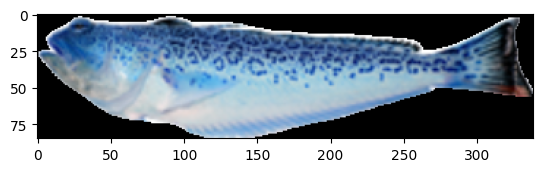

---


In [9]:

import matplotlib.pyplot as plt

for mask_id in range(len(output[1])):
    out_new = model_classifier.batch_inference([output[1][mask_id]])
    print(out_new)
    plt.imshow(output[1][mask_id])
    plt.show()
    print("---")

In [10]:
import numpy

In [11]:
numpy.__version__

'1.23.5'